In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
from pyhive import hive
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split 
from scipy.interpolate import interp1d
from datetime import time
from matplotlib.pyplot import figure
from modules.Cleaner import Cleaner

In [2]:
#database connection
conn = hive.Connection(host="192.168.1.241", port=10000, username="hive")

In [3]:
#use command
cursor = conn.cursor()
cursor.execute("use RoadNetwork")

In [4]:
#defining constant variables
fTag = "flowvalue"
sTag = "speedvalue"
dTag = "measurementdatetime"
kTag = "density"

In [5]:
#situational variables limiting the data set to be read from the database
reference = "RWS01_MONIBAS_0271hrl0778ra" 
datesList = [("2020-02-03 00:00:00.0", "2020-02-10 00:00:00.0")]

In [6]:
sql = "SELECT measurementdatetime, flowvalue, speedvalue FROM MeasurementPoint WHERE"
for i in datesList:
    startDate = i[0]
    endDate = i[1]
    sql = sql + " reference = '" + reference + "' AND measurementdatetime > '" + startDate + "' AND measurementdatetime < '" + endDate + "' OR"
sql = sql[:-3]
sql = sql + " order by measurementdatetime"
measurementPoint = pd.read_sql(sql, conn)

In [7]:
#check if the dataset was extracted succesfully
measurementPoint.head() 

,measurementdatetime,flowvalue,speedvalue
0,2020-02-03 00:01:00,60.0,81.0
1,2020-02-03 00:07:00,300.0,117.0
2,2020-02-03 00:12:00,240.0,104.5
3,2020-02-03 00:18:00,240.0,110.5
4,2020-02-03 00:24:00,180.0,126.5


In [8]:
measurementPoint.shape[0]

1716

In [9]:
dayCount = 0
dates = []

for index, row in measurementPoint.iterrows():
    if (row[dTag].date() not in dates):
        dates.append(row[dTag].date())


In [10]:
timeSeriesFreq = int(measurementPoint.shape[0] / len(dates))
timeSeriesFreq

245

In [11]:
#selecting sub-datasets
flowSeries = pd.concat([measurementPoint[fTag]], axis = 1, sort = False)
speedSeries = pd.concat([measurementPoint[sTag]], axis = 1, sort = False)

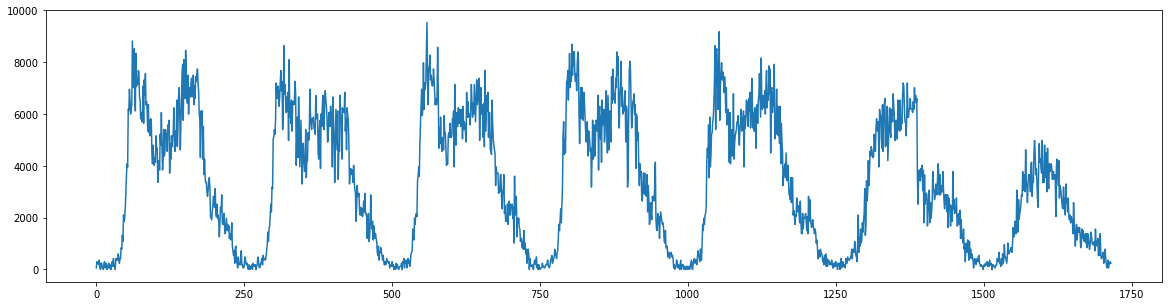

In [12]:
#ploting flow data 
plt.plot(flowSeries)  
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.show()

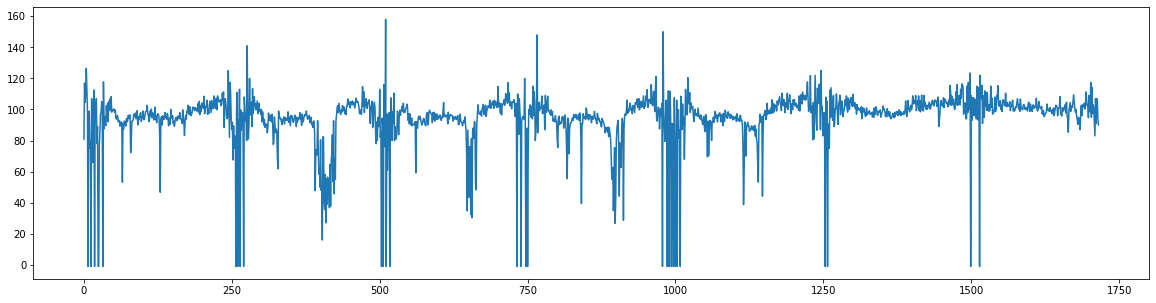

In [13]:
#plotting speed data
plt.plot(speedSeries)  
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.show()

In [14]:
cleaner = Cleaner()

In [15]:
flowSeries = cleaner.cleanFlow(flowSeries)

In [16]:
#display new descriptive statistical values
flowMean = flowSeries.mean()[0] #mean
flowSDeviation = flowSeries.std()[0] #standard deviation
print("flow mean: " + str(flowMean))
print("flow standard deviation: " + str(flowSDeviation))

flow mean: 3365.3146853146854
flow standard deviation: 2517.7826713629815


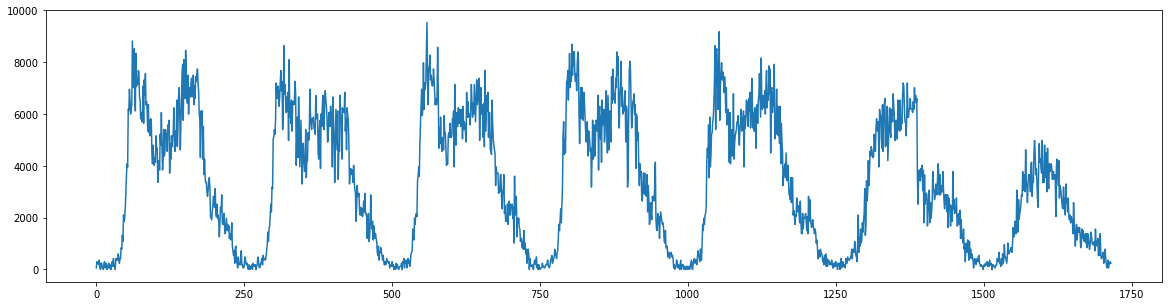

In [17]:
#ploting flow data 
plt.plot(flowSeries)  
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.show()  

In [18]:
#time series for flow data with cleaning
flow_result_add = seasonal_decompose(flowSeries[fTag], model='additive', freq = timeSeriesFreq, extrapolate_trend='freq')

# Flow time series 

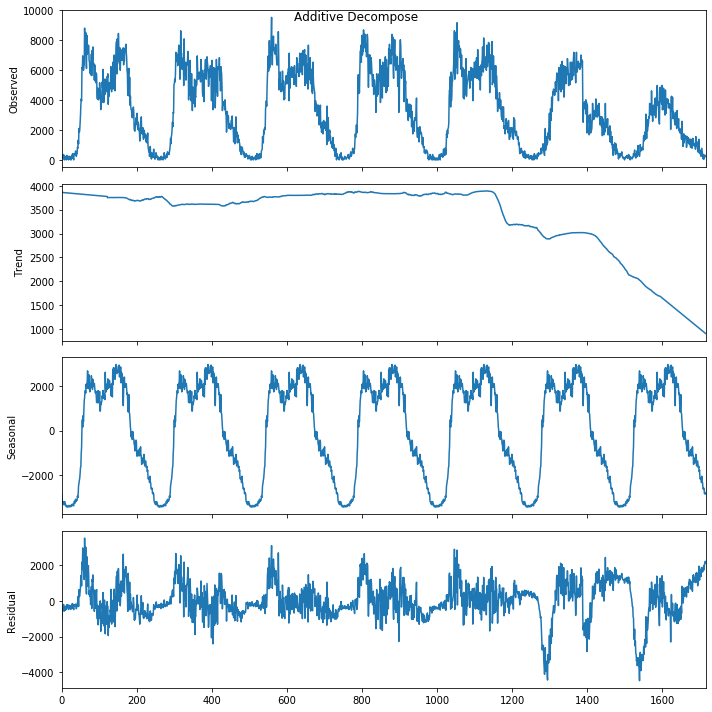

In [19]:
#ploting the time series for flow data 
plt.rcParams.update({'figure.figsize': (10,10)})
flow_result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

In [20]:
speedSeries = cleaner.cleanSpeed(speedSeries)

/home/roger/Templates/InternshipMMGuide/Analysis/modules/Cleaner.py:74: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  speedSeries.set_value(index, sTag, speedMean)


In [21]:
#getting descriptive statistical values for the speed data
speedMean = speedSeries.mean()[0] #mean
speedSDeviation = speedSeries.std()[0] #standard deviation

In [22]:
#getting NEW descriptive statistical values for the speed data
speedMean = speedSeries.mean()[0] #mean
speedSDeviation = speedSeries.std()[0] #standard deviation
#printing descriptive statistical vlaues of the speed data
print("mean: " + str(speedMean))
print("sDeviation: " + str(speedSDeviation))

mean: 96.39925816023747
sDeviation: 11.9610351062676


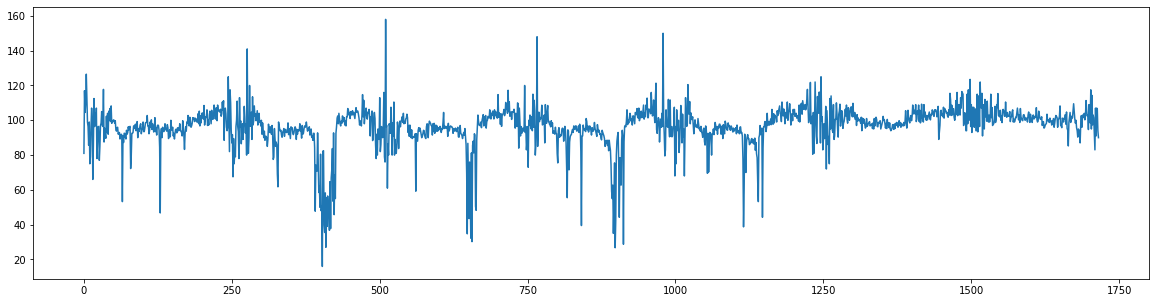

In [23]:
#ploting speed data 
plt.plot(speedSeries)  
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.show()  

In [24]:
#time series for speed data 
speed_result_add = seasonal_decompose(speedSeries[sTag], model='additive', freq = timeSeriesFreq, extrapolate_trend='freq')

# Speed time series 

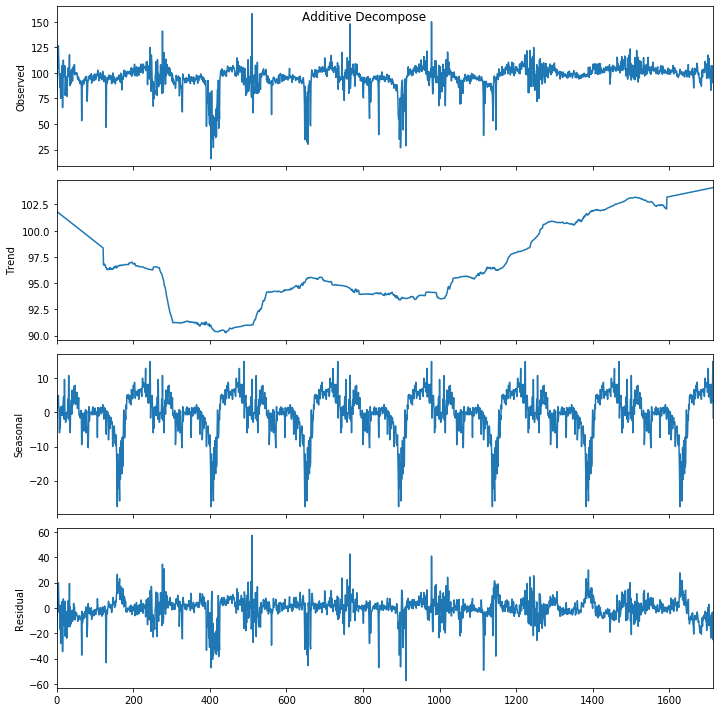

In [25]:
#ploting the time series for speed data 
plt.rcParams.update({'figure.figsize': (10,10)})
speed_result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

# Flow box plot

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb8f0373950>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb8f0336690>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb8f0326f50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb8f0333c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb8f033d610>],
 'means': []}

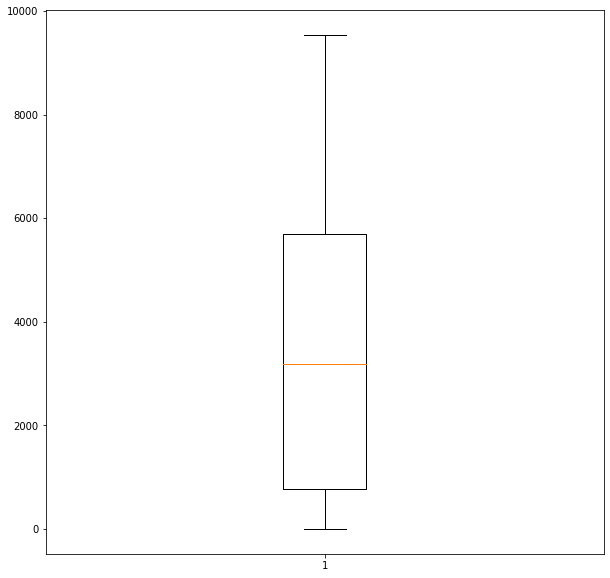

In [26]:
#flow boxplot
plt.boxplot(flowSeries[fTag])

# Speed box plot

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb8f029f290>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb8f029fd50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb8f0296690>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb8f02a47d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb8f02a4cd0>],
 'means': []}

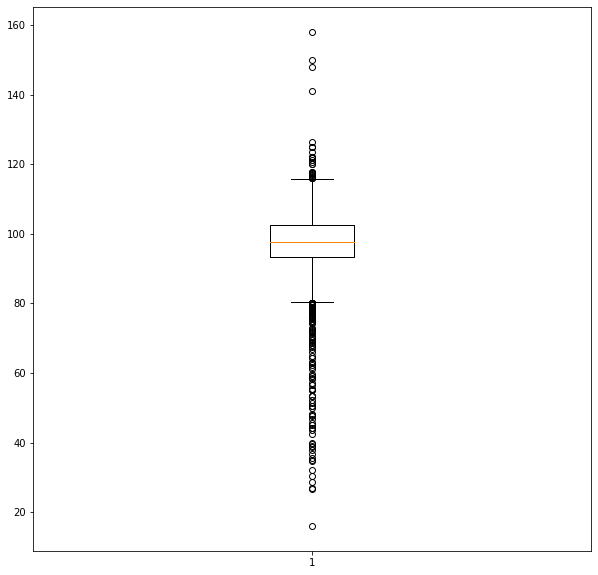

In [27]:
#speed boxplot
plt.boxplot(speedSeries[sTag])

In [28]:
densitySeries = pd.DataFrame(columns = [kTag])

for index, row in flowSeries.iterrows():
    density = row[fTag] / speedSeries.iloc[[index][0]][sTag]
    auxDF = pd.DataFrame([[density]], columns = [kTag])
    densitySeries = densitySeries.append(auxDF, ignore_index = True)


In [29]:
densitySeries

,density
0,0.740741
1,2.564103
2,2.296651
3,2.171946
4,1.422925
...,...
1711,0.659341
1712,1.682243
1713,2.253521
1714,3.191489


In [34]:
#display new descriptive statistical values
densityMean = densitySeries.mean()[0] #mean
densitySDeviation = densitySeries.std()[0] #standard deviation
print("density mean: " + str(densityMean))
print("density standard deviation: " + str(densitySDeviation))

density mean: 37.263286867124336
density standard deviation: 31.099484473591474


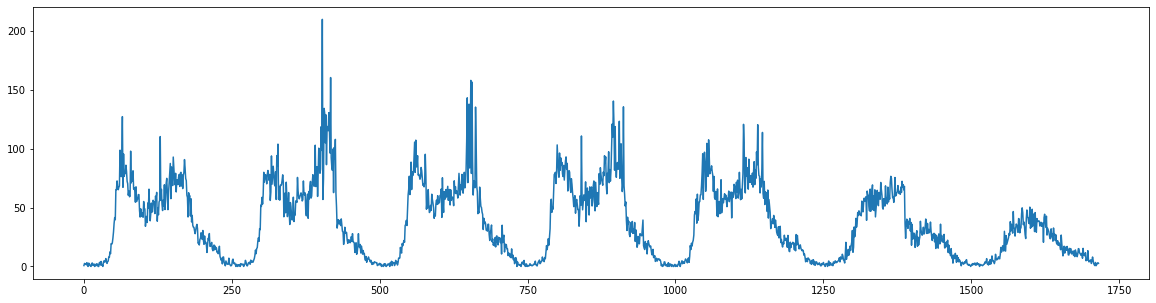

In [30]:
#ploting density data 
plt.plot(densitySeries)  
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.show()  

In [31]:
density_result_add = seasonal_decompose(densitySeries[kTag], model='additive', freq = timeSeriesFreq, extrapolate_trend='freq')

# Density time series

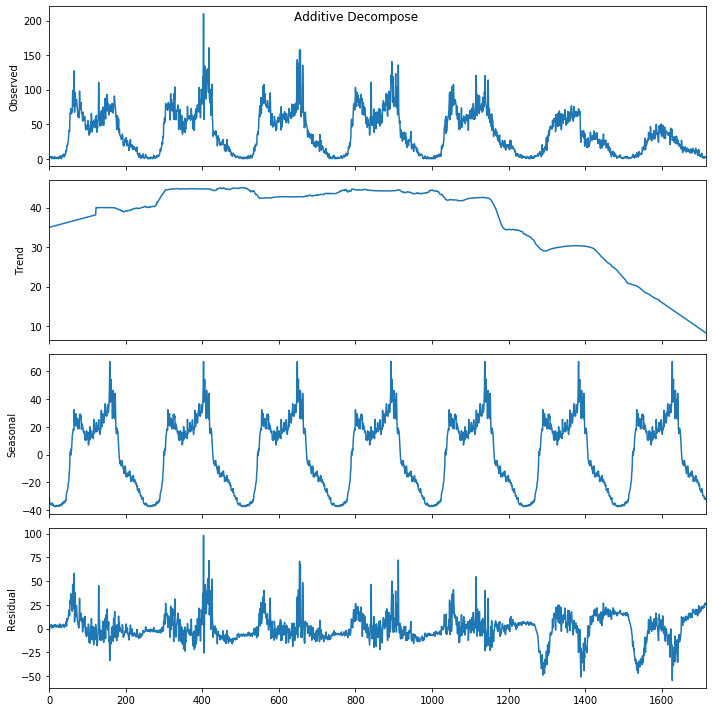

In [32]:
#ploting the time series for density 
plt.rcParams.update({'figure.figsize': (10,10)})
density_result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

# Density box plot

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb8f0548350>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb8f19f1810>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb8f29cb5d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb8f0548110>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb8f19a9610>],
 'means': []}

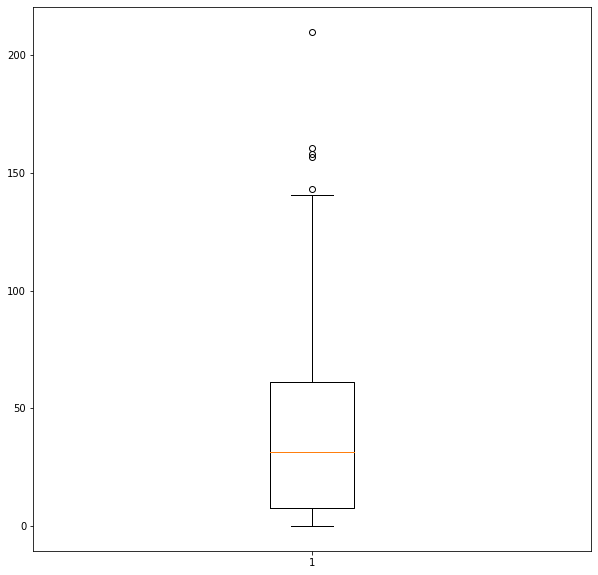

In [33]:
#density boxplot
plt.boxplot(densitySeries[kTag])